In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive/")

In [37]:
from scipy.io import loadmat
from scipy.special import softmax

import pandas as pd
import numpy as np


import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms


import time
import os
import copy

import cv2
from PIL import Image
import albumentations 
from albumentations import pytorch
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import warnings
warnings.filterwarnings('once')


plt.ion()   # interactive mode

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# print(torch.cuda.get_device_name(device))

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
#Loading and Reading the data
#The data available for development(devtoolkit) for cars classification problem is loaded 
#which can be utilized for training and testing.

In [31]:
#Read all the .mat files with class and bounding box information
cars_train_annos = loadmat('/content/drive/My Drive/cars_devkit1/cars_train_annos.mat')
cars_test_annos = loadmat('/content/drive/My Drive/cars_devkit1/cars_test_annos.mat')
cars_labels = loadmat('/content/drive/My Drive/cars_devkit1/cars_meta.mat')
cars_test_annos_with_labels = loadmat('/content/drive/My Drive/cars_devkit1/cars_test_annos_withlabels.mat')

In [ ]:
#Data EDA including Data Transformation

In [11]:
cars_train_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
         (array([[78]], dtype=uint8), array([[526]], dtype=uint16), 

In [12]:
cars_test_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
         (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array(['08040.jpg'], dtype='<U9')),
         (array([[77]],

In [14]:
cars_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
         array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Type-S 2008'], dtype='<U20'),
         array(['Acura TSX Sedan 2012'], dtype='<U20'),
         array(['Acura Integra Type R 2001'], dtype='<U25'),
         array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
         array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
         array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
         array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
         array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
         array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
         array(['Audi A5 Coupe 2012'], dtype='<U18'),
         array(['Audi TTS Coupe 2012'], d

In [15]:
cars_test_annos_with_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array([[17]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
         (array([[33]], dtype=uint8), array([[142]], dtype=uint8), arra

In [16]:
type(cars_labels)

dict

In [17]:
car_labels_arr = cars_labels['class_names'][0]  # storing class names in a nd array

In [18]:
car_labels_arr

array([array(['AM General Hummer SUV 2000'], dtype='<U26'),
       array(['Acura RL Sedan 2012'], dtype='<U19'),
       array(['Acura TL Sedan 2012'], dtype='<U19'),
       array(['Acura TL Type-S 2008'], dtype='<U20'),
       array(['Acura TSX Sedan 2012'], dtype='<U20'),
       array(['Acura Integra Type R 2001'], dtype='<U25'),
       array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
       array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
       array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
       array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
       array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
       array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
       array(['Audi A5 Coupe 2012'], dtype='<U18'),
       array(['Audi TTS Coupe 2012'], dtype='<U19'),
       array(['Audi R8 Coupe 2012'], dtype='<U18'),
       array(['Audi V8 Sedan 1994'], dtype='<U18'),
       array(['Audi 100 Sedan 1994'], dtype='<U19'),
       arra

In [19]:
type(car_labels_arr)

numpy.ndarray

In [20]:
#Store the car classes as a dataframe column
df = pd.DataFrame(car_labels_arr)
df.head()

,0
0,[AM General Hummer SUV 2000]
1,[Acura RL Sedan 2012]
2,[Acura TL Sedan 2012]
3,[Acura TL Type-S 2008]
4,[Acura TSX Sedan 2012]


In [21]:
#unlist the records and provide the column name
df[0] = df[0].apply(lambda x:x[0])
df.columns = ['Car_MakeModelYr']

In [92]:
df.to_csv("Car_MakeModelYr.csv")

In [22]:
df.head()

,Car_MakeModelYr
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [23]:
# transform the annotations available in annotation key of cars_train_annos dictionary to a structured dataframe format
# which can be used for train and test

# print(cars_train_annos['annotations'][0]) #accessing the key value from dict
# print(type(cars_train_annos['annotations'][0]))
# print(type(cars_train_annos['annotations'][0][0]))

# for arr in cars_train_annos['annotations'][0]:
#   for row in arr:
#     print(row.flat[0])  

#using list comprehension instead of for loop for computational efficiency
cars_train = [[row.flat[0] for row in arr] for arr in cars_train_annos['annotations'][0]]
columns_train = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "car_class", "img_fname"]
df_train = pd.DataFrame(cars_train, columns=columns_train)
print(df_train)
df_train['car_class'] = df_train['car_class']-1 #In Pytorch,labels start from 0 index.

#print(cars_test_annos_with_labels["annotations"][0])
cars_test = [[row.flat[0] for row in arr] for arr in cars_test_annos_with_labels["annotations"][0]]
columns_test = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2","car_class","img_fname"]
df_test = pd.DataFrame(cars_test, columns=columns_test)
df_test['car_class'] = df_test['car_class']-1


      bbox_x1  bbox_y1  bbox_x2  bbox_y2  car_class  img_fname
0          39      116      569      375         14  00001.jpg
1          36      116      868      587          3  00002.jpg
2          85      109      601      381         91  00003.jpg
3         621      393     1484     1096        134  00004.jpg
4          14       36      133       99        106  00005.jpg
...       ...      ...      ...      ...        ...        ...
8139        3       44      423      336         78  08140.jpg
8140      138      150      706      523        196  08141.jpg
8141       26      246      660      449        163  08142.jpg
8142       78      526     1489      908        112  08143.jpg
8143       20      240      862      677         17  08144.jpg

[8144 rows x 6 columns]


In [66]:
df_train.head()
df_train.groupby('car_class').count().to_csv("counting.csv")

In [25]:
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,car_class,img_fname
0,30,52,246,147,180,00001.jpg
1,100,19,576,203,102,00002.jpg
2,51,105,968,659,144,00003.jpg
3,67,84,581,407,186,00004.jpg
4,140,151,593,339,184,00005.jpg


count    196.00000
mean      41.55102
std        4.33382
min       24.00000
25%       39.75000
50%       42.00000
75%       44.00000
max       68.00000
Name: car_class, dtype: float64
Int64Index([118,  78, 166, 160,  55, 143, 193,  97,  19, 190,
            ...
             25, 141,  44,   9,   1, 174,  63, 157,  98, 135],
           dtype='int64', length=196)


Text(0.5, 1.0, 'Distibution of class counts')

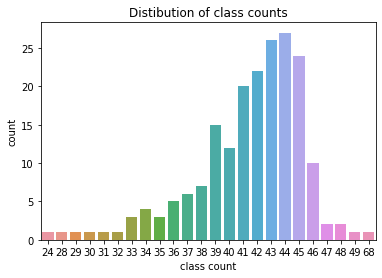

In [90]:
car_class_count = df_train['car_class'].value_counts()
car_class_count.to_csv('counting-class distribution.csv')
print(car_class_count.describe())
print(car_class_count.index)
sns.countplot(car_class_count)
plt.xlabel('class count')
plt.title('Distibution of class counts')

In [2]:
abc= pd.read_csv(r'/content/drive/My Drive/labelclasses.csv')

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

C:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
abc.head()

,car_class,car_class_count
0,1,45
1,2,32
2,3,43
3,4,42
4,5,41


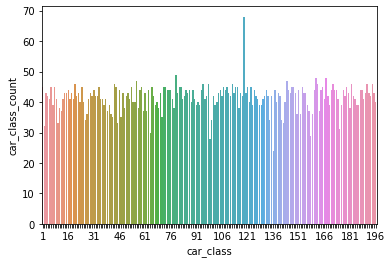

In [5]:
chart = sns.barplot(abc.car_class,abc.car_class_count)
for ind, label in enumerate(chart.get_xticklabels()):
    if ind % 15 == 0: # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
#Additional (to experiment with albumentations and Pytorch)

In [27]:
class CarsDataset(Dataset):
    def __init__(self, devfolder, df=None, transform = transforms.Compose([transforms.ToTensor()])):
        self.devfolder = devfolder
        self.labels = df['car_class'].values
        self.image_fname = df['img_fname'].values
        self.bboxes = df[["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"]].values
        self.image_files_list = [s for s in os.listdir(devfolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def crop_bbox(self,bbox,img_fname):
        """ Method cropps image by provided in .mat file bounding boxes
        """
        image = cv2.imread(img_fname)
        l1, l0,_ = image.shape
        
        b0 = bbox[2] - bbox[0]
        b1 = bbox[3] - bbox[1]
        x0n,x1n = max(int(bbox[0] - b0*0.05),0), min(int(bbox[2] + b0*0.05),l0-1)
        y0n,y1n = max(int(bbox[1] - b1*0.05),0), min(int(bbox[3] + b1*0.05),l1-1)
                
        image = image[y0n:y1n,x0n:x1n]
        return  image
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.datafolder, self.image_fname[idx])
        label = self.labels[idx]
        image = self.crop_bbox(self.bboxes[idx], img_name)
        
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        #Uncomment next 5 rows for training and comment last 3
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

            return image, label
        # image = Image. fromarray(image).convert('RGB')
        # image = self.transform(image)
        # return image, label

In [39]:
#Set transforms for train and val sets
data_transforms = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    ToTensorV2()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.Normalize(),
    ToTensorV2()
    ])

#Create Datsets using previously created class
train_set = CarsDataset(devfolder=r'/content/drive/My Drive/cars_trainn', df=df_train, transform=data_transforms)
test_set = CarsDataset(devfolder=r'/content/drive/My Drive/cars_testt',df=df_test, transform=data_transforms_test)
train_sampler = torch.utils.data.SubsetRandomSampler(list(range(len(os.listdir(r'/content/drive/My Drive/cars_trainn')))))

#Using small batch size due to big images size, as I'm training on free GPU with Google Colab
batch_size = 8
num_workers = 2

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

dataset_sizes = {'train': len(train_set), 'val':len(test_set)}

In [91]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

import sys
import errno

try:
    # Get a batch of training data
    inputs, classes = next(iter(train_loader))
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    imshow(out)
except IOError as e:
    if e.errno == errno.EPIPE:
        pass

In [50]:
#Define metrics for classification
def performance_metrics(true,pred):
    
    precision = metrics.precision_score(true,pred,average='macro', labels=np.unique(pred))
    recall = metrics.recall_score(true,pred,average='macro', labels=np.unique(pred))
    f1_score = metrics.f1_score(true,pred,average='macro', labels=np.unique(pred))
    
    return [precision, recall, f1_score]
    

    

def train_model(model, criterion, optimizer, scheduler,model_fname, num_epochs=25 ):
    
    time_start = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0
    
    loss_list_val = []
    loss_list_train = []
    acc_list_val = []
    acc_list_train = []
        
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('='*85)
        
        for phase in ['train', 'val']:
            
            if phase=='train':
                scheduler.step(epoch_acc)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            metrics_list = []
            precision, recall, f1_score = 0.0, 0.0, 0.0
            
            #Iterate over the dataloader
            
            for inputs, classes in loader:
                inputs = inputs.to(device)
                classes = classes.to(device)
                                
                optimizer.zero_grad()
                
                #forward propagation
                with torch.set_grad_enabled(phase=='train'):
                    
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)   
                    loss = criterion(outputs, classes)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                #Calculate statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==classes.data)
               
                metrics_list = performance_metrics(classes.cpu(), preds.cpu())
                precision += metrics_list[0]
                recall += metrics_list[1]
                f1_score += metrics_list[2]
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)
            else:
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)
           
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('{} Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1_Score: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, precision/len(loader), recall/len(loader), f1_score/len(loader)))
            
        print()
        
    time_elapsed = time.time() - time_start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"/content/drive/My Drive/{model_fname}" 
    torch.save(model.state_dict(), path)
    
    return  loss_list_train, loss_list_val, acc_list_train, acc_list_val                   
            

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
# model_ft.aux_logits = False

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=2, threshold = 0.9)

try:
    loss_list_train, loss_list_val, acc_list_train, acc_list_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,'res50.pth',num_epochs = 15)
except IOError as e:
    if e.errno == errno.EPIPE:
        pass    

In [ ]:
plt.plot(loss_list_train, label='train')
plt.plot(loss_list_val, label='val')
plt.title('Training and Validation Loss for 15 epochs')
plt.legend()
plt.show()

In [ ]:
plt.plot(acc_list_train, label='train')
plt.plot(acc_list_val, label='val')
plt.title('Training and Validation Accuracy for 15 epochs')
plt.legend()
plt.show()

In [ ]:
data_transforms_test = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

df = pd.read_csv('/content/drive/My Drive/df_test.csv')
df['class'] = df['class']-1
test_set = CarsDataset(datafolder='/content/drive/My Drive/cars_testt',df=df, transform=data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


def test_set_accuracy(model, testloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the model on the test images: %d %%' % (
        100 * correct / total))
    


def load_model(model_file):
    model_ft = models.resnext50_32x4d(pretrained=True) 
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 196)
    checkpoint = torch.load(model_file)
    model_ft.load_state_dict(checkpoint)
    return model_ft
    
    
model=load_model(f'/content/drive/My Drive/resnext50_93.4.pth')
model.eval()

test_set_accuracy(model,test_loader)

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict_one_image(model,img_fname,device, transforms = None):

    img = cv2.imread(img_fname)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    image = Image. open(img_fname).convert('RGB')
    image_tr= data_transforms_test(image)
    data = image_tr.expand(1,-1,-1,-1)

    probs = nn.Softmax(dim = 1)
    output = model(data)
    output = probs(output)
    _, predicted = torch.max(output.data, 1)
    img_plot(img)
    prediction_bar(output)
    
    return predicted

def prediction_bar(output):
    
    output = output.detach().numpy()
    pred_labels = output.argsort()[0]
    pred_labels = np.flip(pred_labels[-1*len(pred_labels):])
    
    prediction, label = [], []
    
    for i in pred_labels[:5]:
        prediction.append(float(output[:,i]*100))
        label.append(str(i))
        
    for i in pred_labels[:5]:
        print('Class: {} , confidence: {:.2f}%'.format(labels[int(i)][0],float(output[:,i])*100))
        
    plt.bar(label,prediction, color='green')
    plt.title("Confidence Score Plot")
    plt.xlabel("Confidence Score")
    plt.ylabel("Class number")
    
    return None

def img_plot(image):
    
    plt.imshow(image)
    plt.show()

image_name = '/content/drive/My Drive/cars_testt/00003.jpg'
predict_one_image(model,image_name, device, transforms = data_transforms_test)    